In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/Autopilot-TensorFlow-master/Autopilot-TensorFlow-master

/content/drive/My Drive/Autopilot-TensorFlow-master/Autopilot-TensorFlow-master


In [3]:
import os
os.listdir()

['.DS_Store',
 'steering_wheel_image.jpg',
 '__pycache__',
 'Self_driving_car.ipynb',
 'README.md',
 'train.py',
 'driving_data.py',
 'model.py',
 'run_dataset.py',
 'run.py',
 'logs',
 'save copy',
 'save',
 'cmd_output',
 'data.txt',
 'driving_dataset']

In [3]:
import scipy.misc
import random
import numpy 
from PIL import Image
import cv2

xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


train_xs = xs[:int(len(xs) * 0.7)] #Change
train_ys = ys[:int(len(xs) * 0.7)] #Change

val_xs = xs[-int(len(xs) * 0.3):] #Change
val_ys = ys[-int(len(xs) * 0.3):] #Change

num_train_images = len(train_xs)
num_val_images = len(val_xs)

print(num_train_images, num_val_images, num_images, sep = '\n')

def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(cv2.resize(cv2.imread(train_xs[(train_batch_pointer + 0) % num_train_images])[-150:], (200, 66)) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(cv2.resize(cv2.imread(val_xs[(val_batch_pointer + 0) % num_val_images])[-150:], (200, 66)) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out


31784
13621
45406


In [0]:
type(cv2.imread( train_xs[(num_train_images) % num_train_images]))


numpy.ndarray

In [0]:
train_xs[:10]

['driving_dataset/0.jpg',
 'driving_dataset/1.jpg',
 'driving_dataset/2.jpg',
 'driving_dataset/3.jpg',
 'driving_dataset/4.jpg',
 'driving_dataset/5.jpg',
 'driving_dataset/6.jpg',
 'driving_dataset/7.jpg',
 'driving_dataset/8.jpg',
 'driving_dataset/9.jpg']

In [0]:
train_ys[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [0]:
val_xs[:10]

['driving_dataset/31785.jpg',
 'driving_dataset/31786.jpg',
 'driving_dataset/31787.jpg',
 'driving_dataset/31788.jpg',
 'driving_dataset/31789.jpg',
 'driving_dataset/31790.jpg',
 'driving_dataset/31791.jpg',
 'driving_dataset/31792.jpg',
 'driving_dataset/31793.jpg',
 'driving_dataset/31794.jpg']

In [0]:
val_ys[:10]

[-0.49462631001519297,
 -0.5033529562751646,
 -0.519235452468313,
 -0.5420992656694387,
 -0.5632177496185702,
 -0.5843362335677015,
 -0.6002187297608499,
 -0.6213372137099813,
 -0.6370451769779303,
 -0.6564183316750674]

In [4]:
import tensorflow as tf
import scipy

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.matmul(h_fc4_drop, W_fc5) + b_fc5 #Linear Activation #Change


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
import os
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
#import driving_data
import model

LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss) #Change
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
  #points to the end of the last batch
  train_batch_pointer = 0
  val_batch_pointer = 0
  for i in range(int(num_images/batch_size)):
    xs, ys = LoadTrainBatch(batch_size)
    train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5}) #Change
    if i % 10 == 0:
      xs, ys = LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
    summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


Instructions for updating:
Use `tf.global_variables_initializer` instead.


INFO:tensorflow:Restoring parameters from save/model.ckpt


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Starting frameofvideo:0
Steering angle: 3.7059214785445795 (pred)	0.0 (actual)
Steering angle: 3.7059214785445795 (pred)	0.0 (actual)
Steering angle: 3.7059214785445795 (pred)	0.0 (actual)
Steering angle: 3.7059214785445795 (pred)	0.0 (actual)
Steering angle: 3.7059214785445795 (pred)	0.0 (actual)
Steering angle: 3.7059214785445795 (pred)	0.0 (actual)
Steering angle: 3.7059214785445795 (pred)	0.0 (actual)
Steering angle: 3.7059214785445795 (pred)	0.0 (actual)
Steering angle: 3.7059214785445795 (pred)	0.0 (actual)
Steering angle: 3.7059214785445795 (pred)	0.0 (actual)
Steering angle: 3.7059214785445795 (pred)	0.0 (actual)
Steering angle: 3.7059214785445795 (pred)	0.0 (actual)


KeyboardInterrupt: ignored

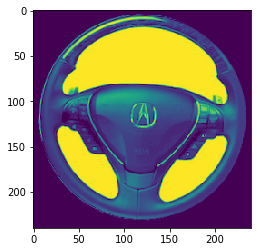

In [11]:
#pip3 install opencv-python

import tensorflow as tf
import scipy.misc
import model
import cv2
from subprocess import call
import math
import matplotlib.pyplot as plt

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.8)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = cv2.imread("driving_dataset/" + str(i) + ".jpg")
    image = cv2.resize(full_image[-150:], (200, 66)) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    plt.imshow( cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    plt.imshow( dst)
    i += 1

cv2.destroyAllWindows()
